In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

        PCa_b      Tref    perm50  CV_ventricles  a_ventricles   EDP_lv  \
0    0.000104  181.8800  0.432887       0.541089       1.47935  7.13285   
1    0.000093  117.2970  0.299218       0.435956       3.51870  4.36058   
2    0.000037   78.5908  0.318741       0.489729       3.26294  7.29318   
3    0.000068  204.1080  0.280034       0.564459       3.48290  5.81285   
4    0.000057  192.8150  0.303769       0.792342       2.23830  2.85869   
..        ...       ...       ...            ...           ...      ...   
995  0.000101  143.8110  0.200636       0.687560       3.18245  2.06155   
996  0.000128   93.3145  0.187213       0.655885       2.91642  1.75915   
997  0.000073   72.4349  0.509966       0.474934       1.80298  3.93620   
998  0.000145   79.0890  0.315106       0.396598       1.00549  7.17315   
999  0.000128  155.7950  0.484251       0.614842       1.89202  3.18508   

      EDP_rv     Rsys    Rpulm  
0    3.79291  2.75361  3.56667  
1    1.39339  2.78153  3.51396  


In [3]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

In [4]:
np.sum(mask)

0    38
dtype: int64

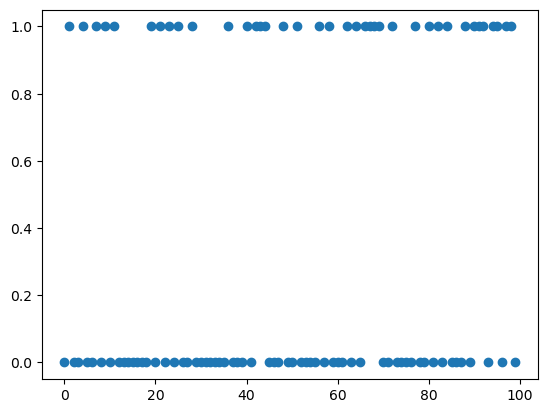

In [5]:
plt.plot(mask,'o')

In [6]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   154.92   6.49  126.15   66.53        956       -487  179.10   2.40   
1   173.98   7.32  154.84   47.91        638       -324  162.16   2.86   
2   172.41   7.04  165.67   19.40        193        -97  180.76   4.16   
3   165.73   7.35  143.18   67.00        912       -486  147.22   2.70   
4   169.99   8.09  155.98   52.72        721       -352  142.09   2.84   
5   153.92   5.97  128.15   69.19       1134       -505  178.36   2.04   
6   170.19   6.93  164.48   34.62        402       -214  154.32   3.42   
7   169.46  10.56  150.17   61.69        741       -399  155.75   2.46   
8   164.23   8.46  148.00   31.88        400       -206  165.12   3.98   
9   164.82   7.16  116.26   69.36       1224       -596  150.67   3.60   
10  173.65   7.30  152.36   60.73        719       -335  153.10   2.35   
11  161.08   8.29  154.38   29.50        266       -152  165.05   3.90   
12  166.16   7.00  135.89   69.35     

In [7]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [8]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(input_masked.values)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [11]:
model.fit(input_masked.values, mask.values.squeeze())

LogisticRegression(random_state=0, solver='liblinear')

In [12]:
reps=50
fail_score = 0
success_score = 0

for j in range(reps):
    fail_input_train = input_failed.sample(37)
    fail_output_train = mask.loc[fail_input_train.index]
    fail_input_test=input_failed.loc[~input_failed.index.isin(fail_input_train.index)]
    fail_output_test=mask.loc[fail_input_test.index]
    for i in range(input_complete.shape[0]):


        complete_input_test=input_complete.iloc[[i]]
        complete_output_test=mask.loc[complete_input_test.index]
        complete_input_train = input_complete.loc[~input_complete.index.isin(complete_input_test.index)]
        complete_output_train = mask.loc[complete_input_train.index]


        y_train = pd.concat([fail_output_train,complete_output_train])
        y_test = pd.concat([fail_output_test,complete_output_test])

        x_train = pd.concat([fail_input_train,complete_input_train])
        x_test= pd.concat([fail_input_test,complete_input_test])

        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(x_train.values, y_train.values.squeeze())

        success_score+=model.predict(complete_input_test.values)/input_complete.shape[0]/reps
        fail_score+=model.score(fail_input_test.values,fail_output_test.values.squeeze())/reps/input_complete.shape[0]

In [13]:
success_score

array([0.60052632])

In [14]:
fail_score

0.6077052631578939

In [15]:
nDim = x_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(x_train.iloc[:,i]),np.max(x_train.iloc[:,i])])
    print(boundsMaxMin[i])
    

[2.25773e-05, 0.000141961]
[60.0088, 217.517]
[0.179306, 0.519518]
[0.400375, 0.796491]
[1.07834, 4.95594]
[1.03757, 7.40647]
[1.03544, 7.39001]
[1.07404, 3.98453]
[1.01728, 3.98399]


In [16]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = param_values
#data1.columns = X_train.columns

Ymean=model.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_42868/2588839841.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [17]:
Ymean.shape

(20480,)

In [18]:
np.sum(Ymean)

8016

In [19]:
Si = []
nMod = y_train.shape[1]
nDim = x_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean, print_to_console=True,calc_second_order=True))

                        ST   ST_conf
(PCa_b,)          0.000000  0.000000
(Tref,)           0.141102  0.036612
(perm50,)         0.071574  0.021985
(CV_ventricles,)  0.089978  0.025207
(a_ventricles,)   0.357868  0.050020
(EDP_lv,)         0.678926  0.053239
(EDP_rv,)         0.509195  0.054510
(Rsys,)           0.241305  0.037105
(Rpulm,)          0.034764  0.014280
                        S1   S1_conf
(PCa_b,)          0.000000  0.000000
(Tref,)           0.003026  0.035775
(perm50,)         0.000713  0.022590
(CV_ventricles,)  0.010493  0.028373
(a_ventricles,)   0.072018  0.056356
(EDP_lv,)         0.338575  0.069195
(EDP_rv,)         0.198805  0.060865
(Rsys,)           0.061534  0.041378
(Rpulm,)         -0.010669  0.017484
Empty DataFrame
Columns: [S2, S2_conf]
Index: []


In [20]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

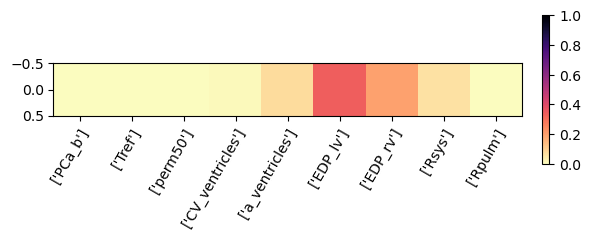

In [21]:
inputs = x_labels.values.tolist()

fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)


ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

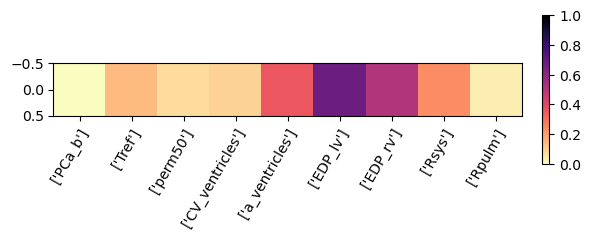

In [22]:
inputs = x_labels.values.tolist()

fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:10],cmap='magma_r',vmin=0,vmax=1)


ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [23]:
np.max(data1[:,4])

4.954046640625

In [24]:
data2=data1[::20]

Text(0.5, 0, 'EDP_lv')

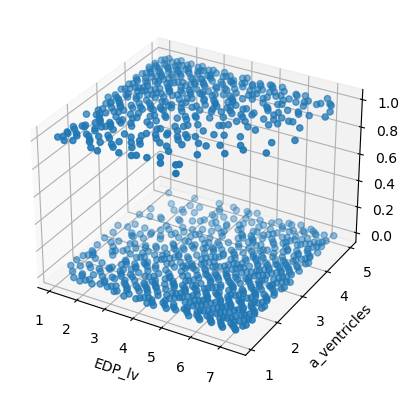

In [25]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data2[:,6],data2[:,4],model.predict(data2))
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

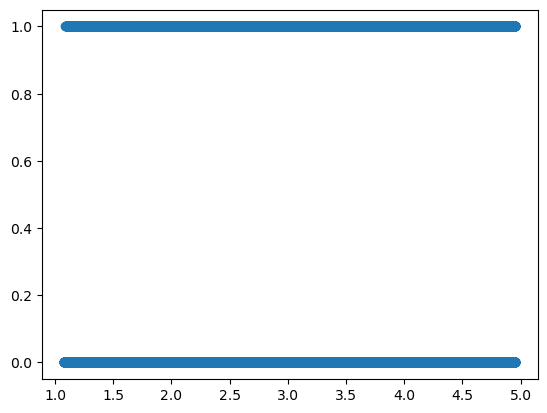

In [26]:
plt.plot(data1[:,4],model.predict(data1),'o')

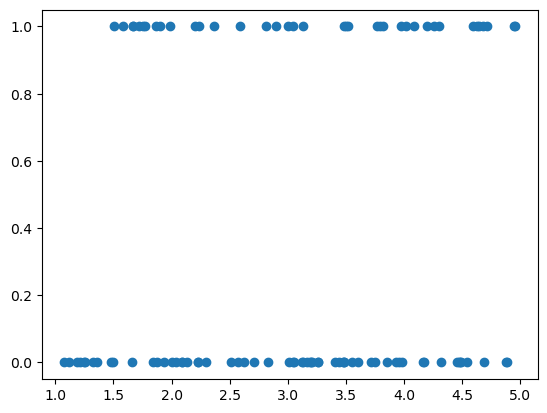

In [27]:
plt.plot(input_masked.iloc[:,4],mask,'o')

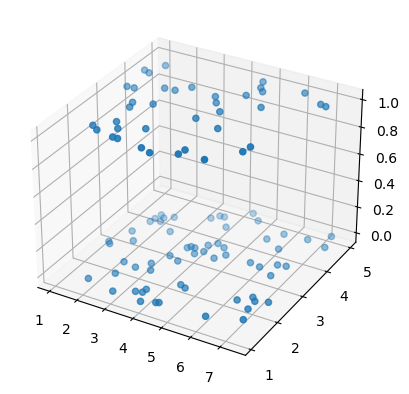

In [28]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(input_masked.iloc[:,6],input_masked.iloc[:,4],mask)

# Emulator

In [29]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

In [30]:
input_masked=input_masked.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [31]:
input_masked.shape

(38, 9)

In [32]:
y_all.shape

(38, 28)

In [33]:
y_all.index[0]

0

In [34]:
y_all

,LVedv,LVedp,LVesv,LVpMax,LVdpdtMax,LVdpdtMin,RVedv,RVedp,RVesv,RVpMax,...,RAvMax,RApMax,LAsvA,LAinflV,LAsvV,RAsvA,RAinflV,RAsvV,A_TAT,V_TAT
0,154.92,6.49,126.15,66.53,956,-487,179.10,2.40,152.68,25.19,...,83.61,2.82,18.96,3.45,6.46,11.22,9.24,10.03,105.548,153.8110
1,173.98,7.32,154.84,47.91,638,-324,162.16,2.86,146.53,14.17,...,73.25,3.24,22.21,0.27,0.82,10.93,3.30,3.40,106.244,85.0980
2,172.41,7.04,165.67,19.40,193,-97,180.76,4.16,177.36,9.17,...,74.44,4.85,17.11,1.27,0.01,12.16,1.36,0.06,104.589,115.6090
3,165.73,7.35,143.18,67.00,912,-486,147.22,2.70,128.10,22.30,...,66.98,2.82,18.97,2.18,5.17,8.82,6.55,7.44,105.634,89.5102
4,169.99,8.09,155.98,52.72,721,-352,142.09,2.84,132.75,15.04,...,65.28,3.03,18.73,0.30,0.00,9.17,2.24,2.09,105.524,91.2550
5,153.92,5.97,128.15,69.19,1134,-505,178.36,2.04,155.63,26.44,...,81.82,2.53,19.63,2.39,4.04,11.01,8.08,8.17,106.175,97.0750
6,170.19,6.93,164.48,34.62,402,-214,154.32,3.42,148.54,13.63,...,65.40,3.85,16.81,1.71,0.00,9.92,1.53,1.14,105.680,163.8770
7,169.46,10.56,150.17,61.69,741,-399,155.75,2.46,138.70,15.06,...,68.54,2.66,21.94,1.09,2.38,8.82,4.43,5.39,106.023,130.5520
8,164.23,8.46,148.00,31.88,400,-206,165.12,3.98,153.98,12.76,...,70.44,4.12,20.19,-0.56,1.61,11.14,2.72,2.83,105.339,94.8909
9,164.82,7.16,116.26,69.36,1224,-596,150.67,3.60,108.40,22.61,...,75.01,3.79,18.33,9.12,14.27,9.84,13.34,13.47,105.561,98.6270


In [35]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(input_masked.values)

In [36]:
y_train

tensor([[1.5492e+02, 6.4900e+00, 1.2615e+02,  ..., 1.0030e+01, 1.0555e+02,
         1.5381e+02],
        [1.7398e+02, 7.3200e+00, 1.5484e+02,  ..., 3.4000e+00, 1.0624e+02,
         8.5098e+01],
        [1.7241e+02, 7.0400e+00, 1.6567e+02,  ..., 6.0000e-02, 1.0459e+02,
         1.1561e+02],
        ...,
        [1.6968e+02, 6.9200e+00, 1.2681e+02,  ..., 1.3300e+01, 1.0515e+02,
         1.5971e+02],
        [1.8984e+02, 6.2500e+00, 1.7313e+02,  ..., 1.4100e+00, 1.0657e+02,
         9.0540e+01],
        [1.5678e+02, 7.1200e+00, 1.1558e+02,  ..., 1.3780e+01, 1.0634e+02,
         1.3184e+02]], dtype=torch.float64)

In [37]:
x_train.shape

torch.Size([38, 9])

In [38]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [39]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[4.30915e-05, 0.000141663]
[60.0088, 213.146]
[0.193135, 0.518036]
[0.411063, 0.796491]
[1.50272, 4.95594]
[1.03757, 7.40647]
[1.03544, 7.09553]
[1.16178, 3.93971]
[1.01728, 3.95163]


In [40]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_42868/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [41]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST   ST_conf
(PCa_b,)          0.056754  0.005926
(Tref,)           0.024702  0.001883
(perm50,)         0.024641  0.002439
(CV_ventricles,)  0.000081  0.000008
(a_ventricles,)   0.132144  0.011729
(EDP_lv,)         0.491395  0.039762
(EDP_rv,)         0.034745  0.003133
(Rsys,)           0.075160  0.007012
(Rpulm,)          0.160350  0.013806
                        S1   S1_conf
(PCa_b,)          0.056644  0.020103
(Tref,)           0.024699  0.013288
(perm50,)         0.024649  0.014341
(CV_ventricles,)  0.000088  0.000816
(a_ventricles,)   0.132079  0.029654
(EDP_lv,)         0.492199  0.054138
(EDP_rv,)         0.034773  0.016178
(Rsys,)           0.074975  0.023950
(Rpulm,)          0.160403  0.031805
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(PCa_b,)          0.213380  0.018124
(Tref,)           0.042053  0.003485
(perm50,)         0.040959  0.003869
(CV_ventricles,)  0.001132  0.000082
(a_ventricles,)   0.107328

                        ST   ST_conf
(PCa_b,)          0.098672  0.008384
(Tref,)           0.024061  0.002381
(perm50,)         0.018154  0.001523
(CV_ventricles,)  0.003555  0.000291
(a_ventricles,)   0.000084  0.000008
(EDP_lv,)         0.655196  0.051406
(EDP_rv,)         0.015863  0.001258
(Rsys,)           0.013233  0.001094
(Rpulm,)          0.171168  0.013788
                        S1   S1_conf
(PCa_b,)          0.098764  0.027455
(Tref,)           0.024063  0.013448
(perm50,)         0.018149  0.011332
(CV_ventricles,)  0.003584  0.004660
(a_ventricles,)   0.000086  0.000823
(EDP_lv,)         0.656197  0.060414
(EDP_rv,)         0.015855  0.010443
(Rsys,)           0.013167  0.009455
(Rpulm,)          0.171282  0.037007
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(PCa_b,)          0.280234  0.028258
(Tref,)           0.051541  0.005086
(perm50,)         0.036832  0.003318
(CV_ventricles,)  0.004794  0.000457
(a_ventricles,)   0.009915

                        ST   ST_conf
(PCa_b,)          0.045589  0.004819
(Tref,)           0.007248  0.000702
(perm50,)         0.032115  0.002688
(CV_ventricles,)  0.000270  0.000027
(a_ventricles,)   0.220878  0.025188
(EDP_lv,)         0.532610  0.047250
(EDP_rv,)         0.281834  0.022173
(Rsys,)           0.000315  0.000029
(Rpulm,)          0.004143  0.000394
                        S1   S1_conf
(PCa_b,)          0.038438  0.018542
(Tref,)           0.007410  0.007903
(perm50,)         0.027685  0.017710
(CV_ventricles,)  0.000198  0.001296
(a_ventricles,)   0.096316  0.037902
(EDP_lv,)         0.415466  0.065108
(EDP_rv,)         0.292334  0.042338
(Rsys,)           0.000328  0.001530
(Rpulm,)          0.004374  0.005468
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                            ST       ST_conf
(PCa_b,)          1.174521e-03  9.561306e-05
(Tref,)           1.152783e-03  1.127344e-04
(perm50,)         4.053055e-04  3.495302e-05
(CV_ventricles,)  9.950000e-01 

In [42]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [43]:
x_labels.values.squeeze().tolist()

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

In [44]:
y_all.columns.tolist()

['LVedv',
 'LVedp',
 'LVesv',
 'LVpMax',
 'LVdpdtMax',
 'LVdpdtMin',
 'RVedv',
 'RVedp',
 'RVesv',
 'RVpMax',
 'RVdpdtMax',
 'RVdpdtMin',
 'LAedv',
 'LAesv',
 'LAvMax',
 'LApMax',
 'RAedv',
 'RAesv',
 'RAvMax',
 'RApMax',
 'LAsvA',
 'LAinflV',
 'LAsvV',
 'RAsvA',
 'RAinflV',
 'RAsvV',
 'A_TAT',
 'V_TAT']

In [45]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

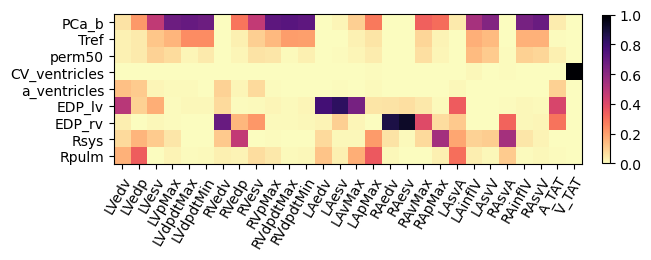

In [46]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

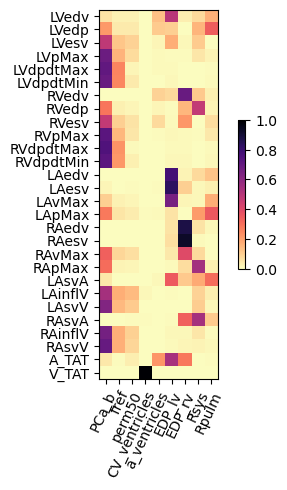

In [47]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [48]:
np.savetxt("Si_total_mech_6.csv", Si_total, delimiter=",")
np.savetxt("Si_first_mech_6.csv", Si_first, delimiter=",")

In [47]:
y_all

,LVedv,LVedp,LVesv,LVpMax,LVdpdtMax,LVdpdtMin,RVedv,RVedp,RVesv,RVpMax,...,RAvMax,RApMax,LAsvA,LAinflV,LAsvV,RAsvA,RAinflV,RAsvV,A_TAT,V_TAT
0,154.92,6.49,126.15,66.53,956,-487,179.10,2.40,152.68,25.19,...,83.61,2.82,18.96,3.45,6.46,11.22,9.24,10.03,105.548,153.8110
1,173.98,7.32,154.84,47.91,638,-324,162.16,2.86,146.53,14.17,...,73.25,3.24,22.21,0.27,0.82,10.93,3.30,3.40,106.244,85.0980
2,172.41,7.04,165.67,19.40,193,-97,180.76,4.16,177.36,9.17,...,74.44,4.85,17.11,1.27,0.01,12.16,1.36,0.06,104.589,115.6090
3,165.73,7.35,143.18,67.00,912,-486,147.22,2.70,128.10,22.30,...,66.98,2.82,18.97,2.18,5.17,8.82,6.55,7.44,105.634,89.5102
4,169.99,8.09,155.98,52.72,721,-352,142.09,2.84,132.75,15.04,...,65.28,3.03,18.73,0.30,0.00,9.17,2.24,2.09,105.524,91.2550
5,153.92,5.97,128.15,69.19,1134,-505,178.36,2.04,155.63,26.44,...,81.82,2.53,19.63,2.39,4.04,11.01,8.08,8.17,106.175,97.0750
6,170.19,6.93,164.48,34.62,402,-214,154.32,3.42,148.54,13.63,...,65.40,3.85,16.81,1.71,0.00,9.92,1.53,1.14,105.680,163.8770
7,169.46,10.56,150.17,61.69,741,-399,155.75,2.46,138.70,15.06,...,68.54,2.66,21.94,1.09,2.38,8.82,4.43,5.39,106.023,130.5520
8,164.23,8.46,148.00,31.88,400,-206,165.12,3.98,153.98,12.76,...,70.44,4.12,20.19,-0.56,1.61,11.14,2.72,2.83,105.339,94.8909
9,164.82,7.16,116.26,69.36,1224,-596,150.67,3.60,108.40,22.61,...,75.01,3.79,18.33,9.12,14.27,9.84,13.34,13.47,105.561,98.6270


In [48]:
y_train

tensor([[1.5492e+02, 6.4900e+00, 1.2615e+02,  ..., 1.0030e+01, 1.0555e+02,
         1.5381e+02],
        [1.7398e+02, 7.3200e+00, 1.5484e+02,  ..., 3.4000e+00, 1.0624e+02,
         8.5098e+01],
        [1.7241e+02, 7.0400e+00, 1.6567e+02,  ..., 6.0000e-02, 1.0459e+02,
         1.1561e+02],
        ...,
        [1.6968e+02, 6.9200e+00, 1.2681e+02,  ..., 1.3300e+01, 1.0515e+02,
         1.5971e+02],
        [1.8984e+02, 6.2500e+00, 1.7313e+02,  ..., 1.4100e+00, 1.0657e+02,
         9.0540e+01],
        [1.5678e+02, 7.1200e+00, 1.1558e+02,  ..., 1.3780e+01, 1.0634e+02,
         1.3184e+02]], dtype=torch.float64)

In [49]:
y_all.copy().drop(y_all.index[i]).values

array([[1.54920e+02, 6.49000e+00, 1.26150e+02, ..., 1.00300e+01,
        1.05548e+02, 1.53811e+02],
       [1.73980e+02, 7.32000e+00, 1.54840e+02, ..., 3.40000e+00,
        1.06244e+02, 8.50980e+01],
       [1.72410e+02, 7.04000e+00, 1.65670e+02, ..., 6.00000e-02,
        1.04589e+02, 1.15609e+02],
       ...,
       [1.69680e+02, 6.92000e+00, 1.26810e+02, ..., 1.33000e+01,
        1.05152e+02, 1.59710e+02],
       [1.89840e+02, 6.25000e+00, 1.73130e+02, ..., 1.41000e+00,
        1.06567e+02, 9.05397e+01],
       [1.56780e+02, 7.12000e+00, 1.15580e+02, ..., 1.37800e+01,
        1.06342e+02, 1.31837e+02]])

In [50]:
nsamp=100
MSE = np.zeros((y_all.shape[0],y_all.shape[1]))

for i in range(y_all.shape[0]):
    y_train = torch.tensor(y_all.copy().drop(y_all.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_all.index[i]).values)
    
    y_test = torch.tensor(y_all.loc[[y_all.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_all.index[i]]].values)
    
    
    
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [51]:
1-MSE.mean(axis=0)/np.var(y_all,axis=0)

LVedv        0.898156
LVedp        0.889814
LVesv        0.959282
LVpMax       0.894550
LVdpdtMax    0.922120
LVdpdtMin    0.969799
RVedv        0.967188
RVedp        0.830236
RVesv        0.945297
RVpMax       0.957161
RVdpdtMax    0.936789
RVdpdtMin    0.954209
LAedv        0.939569
LAesv        0.978175
LAvMax       0.829283
LApMax       0.654697
RAedv        0.967735
RAesv        0.990196
RAvMax       0.950678
RApMax       0.845222
LAsvA        0.390839
LAinflV      0.714373
LAsvV        0.821137
RAsvA        0.584313
RAinflV      0.948650
RAsvV        0.957990
A_TAT        0.025494
V_TAT        0.999324
dtype: float64

In [52]:
MSE.shape

(38, 28)

In [53]:
MSE[0].shape

(28,)

In [54]:
np.var(y_all,axis=0).shape

(28,)

In [55]:
R2=np.zeros((18,28))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_all,axis=0))

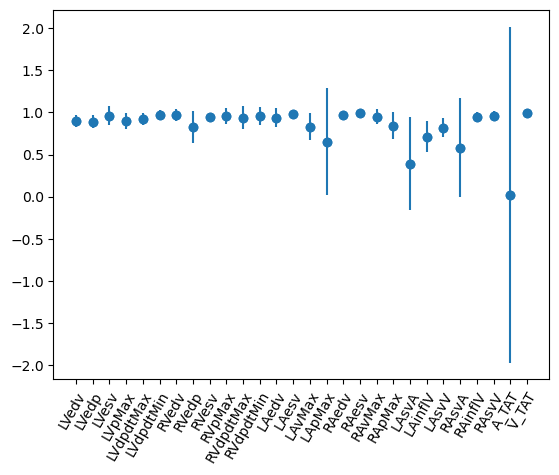

In [56]:
fig, ax = plt.subplots()


ax.scatter(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)))
plt.errorbar(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [57]:
y_calibration = y_all.loc[:,['V_TAT','A_TAT','LVpMax','LVedv','LVesv']]

In [58]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [59]:
y_calibration2=y_calibration.join(y_calibration2)

In [60]:
MSE = np.zeros((y_calibration.shape[0],y_calibration.shape[1]))

for i in range(y_calibration.shape[0]):
    y_train = torch.tensor(y_calibration.copy().drop(y_calibration.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_calibration.index[i]).values)
    
    y_test = torch.tensor(y_calibration.loc[[y_calibration.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_calibration.index[i]]].values)
    print(y_test)
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

tensor([[153.8110, 105.5480,  66.5300, 154.9200, 126.1500]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[ 85.0980, 106.2440,  47.9100, 173.9800, 154.8400]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[115.6090, 104.5890,  19.4000, 172.4100, 165.6700]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[ 89.5102, 105.6340,  67.0000, 165.7300, 143.1800]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[ 91.2550, 105.5240,  52.7200, 169.9900, 155.9800]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[ 97.0750, 106.1750,  69.1900, 153.9200, 128.1500]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[163.8770, 105.6800,  34.6200, 170.1900, 164.4800]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[130.5520, 106.0230,  61.6900, 169.4600, 150.1700]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[ 94.8909, 105.3390,  31.8800, 164.2300, 148.0000]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[ 98.6270, 105.5610,  69.3600, 164.8200, 116.2600]],
       dtype=torch.float64)
0
1
2
3
4
tensor([[1

In [61]:
R2=np.zeros((18,5))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_calibration,axis=0))

In [62]:
R2.std(axis=0)

array([2.80536408e-04, 1.94712348e+00, 9.20208091e-02, 7.46154406e-02,
       1.23965272e-01])

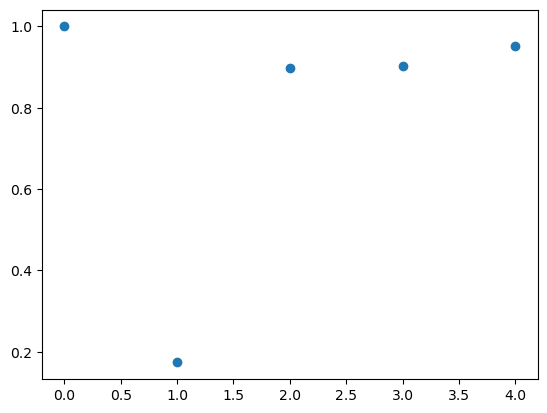

In [63]:
plt.plot(np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),'o')

In [64]:
y_calibration.columns.values.tolist()

['V_TAT', 'A_TAT', 'LVpMax', 'LVedv', 'LVesv']

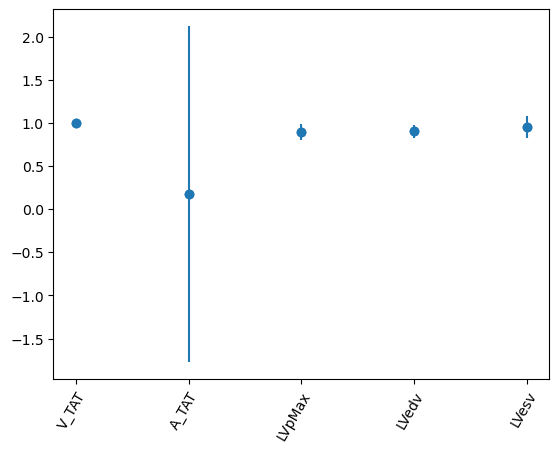

In [65]:
fig, ax = plt.subplots()


ax.scatter(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)))
plt.errorbar(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [66]:
X_train = torch.tensor(input_masked.values)

In [67]:
y_train=torch.tensor(y_calibration.values)

In [68]:
X_train

tensor([[9.2576e-05, 1.1730e+02, 2.9922e-01, 4.3596e-01, 3.5187e+00, 4.3606e+00,
         1.3934e+00, 2.7815e+00, 3.5140e+00],
        [5.6910e-05, 1.9281e+02, 3.0377e-01, 7.9234e-01, 2.2383e+00, 2.8587e+00,
         3.0924e+00, 2.5654e+00, 1.6876e+00],
        [4.9742e-05, 1.7501e+02, 4.3148e-01, 5.8374e-01, 3.0013e+00, 1.0439e+00,
         1.8597e+00, 1.4210e+00, 2.4546e+00],
        [8.1705e-05, 1.4642e+02, 2.8974e-01, 7.5150e-01, 4.6781e+00, 2.7524e+00,
         6.8949e+00, 3.7776e+00, 3.4949e+00],
        [6.1959e-05, 2.0430e+02, 3.6294e-01, 7.3606e-01, 2.5859e+00, 4.8290e+00,
         6.3350e+00, 3.9154e+00, 2.6342e+00],
        [1.3538e-04, 9.6930e+01, 4.9819e-01, 6.9215e-01, 1.8686e+00, 5.0336e+00,
         1.6116e+00, 3.0212e+00, 3.9516e+00],
        [6.3489e-05, 1.9178e+02, 4.2516e-01, 4.1106e-01, 4.0185e+00, 1.2443e+00,
         5.4139e+00, 2.9899e+00, 3.5729e+00],
        [6.8716e-05, 1.4706e+02, 2.8100e-01, 5.1673e-01, 4.7152e+00, 4.1999e+00,
         4.7863e+00, 3.9397e+0

In [69]:
emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4


In [70]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([torch.min(X_train[:,i]).detach().numpy(),torch.max(X_train[:,i]).detach().numpy()])
    print(boundsMaxMin[i])

[array(4.30915e-05), array(0.00014166)]
[array(60.0088), array(213.146)]
[array(0.193135), array(0.518036)]
[array(0.411063), array(0.796491)]
[array(1.50272), array(4.95594)]
[array(1.03757), array(7.40647)]
[array(1.03544), array(7.09553)]
[array(1.16178), array(3.93971)]
[array(1.01728), array(3.95163)]


In [71]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_81104/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [72]:
Si = []
nMod = y_train.shape[1]
nDim = X_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                            ST       ST_conf
(PCa_b,)          5.730603e-06  6.447560e-07
(Tref,)           7.604523e-06  9.222553e-07
(perm50,)         7.787059e-07  7.863755e-08
(CV_ventricles,)  1.000031e+00  6.068268e-02
(a_ventricles,)   3.294067e-05  4.108809e-06
(EDP_lv,)         4.908616e-05  5.233205e-06
(EDP_rv,)         5.091232e-05  6.636023e-06
(Rsys,)           1.686452e-05  1.430011e-06
(Rpulm,)          2.557992e-05  3.915219e-06
                        S1   S1_conf
(PCa_b,)          0.000003  0.000221
(Tref,)          -0.000013  0.000217
(perm50,)         0.000002  0.000079
(CV_ventricles,)  0.999922  0.081566
(a_ventricles,)   0.000015  0.000496
(EDP_lv,)         0.000041  0.000563
(EDP_rv,)         0.000011  0.000550
(Rsys,)           0.000074  0.000333
(Rpulm,)         -0.000111  0.000451
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST       ST_conf
(PCa_b,)          0.078243  7.255941e-03
(Tref,)           0.003708  3.434974e-04
(perm50,

In [73]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


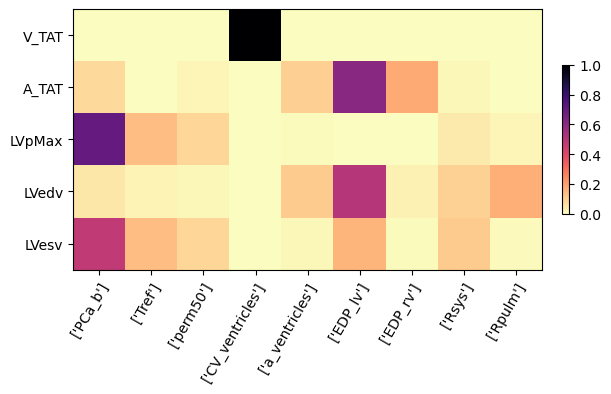

In [74]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

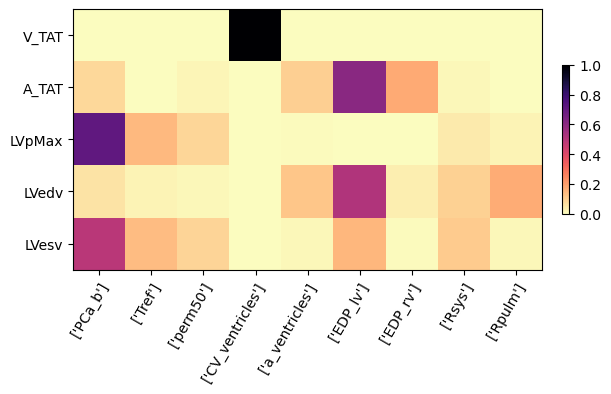

In [75]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [76]:
emulator.predict(data1).detach().numpy()[:,4]

array([159.60545, 118.35965, 148.36653, ..., 122.86255, 134.99808,
       135.9856 ], dtype=float32)

Text(0.5, 0, 'EDP_lv')

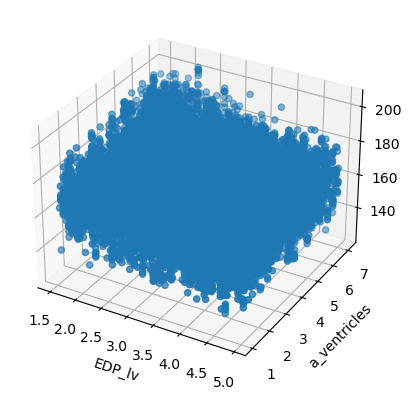

In [77]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data1[:,4],data1[:,6],emulator.predict(data1).detach().numpy()[:,3])
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

In [78]:
Si[i].to_df()

[                        ST   ST_conf
 (PCa_b,)          0.491481  0.046184
 (Tref,)           0.139482  0.012765
 (perm50,)         0.089657  0.010028
 (CV_ventricles,)  0.000128  0.000013
 (a_ventricles,)   0.015451  0.001657
 (EDP_lv,)         0.152131  0.012947
 (EDP_rv,)         0.004864  0.000460
 (Rsys,)           0.107628  0.010203
 (Rpulm,)          0.014384  0.001444,
                         S1   S1_conf
 (PCa_b,)          0.475967  0.057304
 (Tref,)           0.136641  0.033616
 (perm50,)         0.083375  0.027430
 (CV_ventricles,)  0.000164  0.000941
 (a_ventricles,)   0.015255  0.010521
 (EDP_lv,)         0.154159  0.035913
 (EDP_rv,)         0.004600  0.006552
 (Rsys,)           0.107885  0.030559
 (Rpulm,)          0.010268  0.011862,
 Empty DataFrame
 Columns: [S2, S2_conf]
 Index: []]

In [79]:
y_calibration

,V_TAT,A_TAT,LVpMax,LVedv,LVesv
0,153.8110,105.548,66.53,154.92,126.15
1,85.0980,106.244,47.91,173.98,154.84
2,115.6090,104.589,19.40,172.41,165.67
3,89.5102,105.634,67.00,165.73,143.18
4,91.2550,105.524,52.72,169.99,155.98
5,97.0750,106.175,69.19,153.92,128.15
6,163.8770,105.680,34.62,170.19,164.48
7,130.5520,106.023,61.69,169.46,150.17
8,94.8909,105.339,31.88,164.23,148.00
9,98.6270,105.561,69.36,164.82,116.26


In [80]:
y_calibration = y_all.loc[:,['V_TAT','LVpMax']]

In [81]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [82]:
y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)

In [83]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

0
1
2


In [84]:
input_masked

,PCa_b,Tref,perm50,CV_ventricles,a_ventricles,EDP_lv,EDP_rv,Rsys,Rpulm
0,0.000093,117.2970,0.299218,0.435956,3.51870,4.36058,1.39339,2.78153,3.51396
1,0.000057,192.8150,0.303769,0.792342,2.23830,2.85869,3.09239,2.56544,1.68758
2,0.000050,175.0130,0.431479,0.583736,3.00127,1.04387,1.85967,1.42103,2.45458
3,0.000082,146.4240,0.289738,0.751501,4.67815,2.75242,6.89489,3.77755,3.49490
4,0.000062,204.2960,0.362944,0.736060,2.58588,4.82903,6.33496,3.91539,2.63424
5,0.000135,96.9297,0.498188,0.692152,1.86865,5.03361,1.61164,3.02116,3.95163
6,0.000063,191.7800,0.425156,0.411063,4.01851,1.24429,5.41391,2.98988,3.57288
7,0.000069,147.0590,0.281004,0.516726,4.71517,4.19987,4.78627,3.93971,1.14365
8,0.000090,65.1695,0.518036,0.711245,4.95594,3.27544,4.65155,1.64056,1.75648
9,0.000142,121.4990,0.312939,0.682026,4.64584,2.70005,7.09553,1.45034,1.55882


In [85]:
boundsMaxMin

[[array(4.30915e-05), array(0.00014166)],
 [array(60.0088), array(213.146)],
 [array(0.193135), array(0.518036)],
 [array(0.411063), array(0.796491)],
 [array(1.50272), array(4.95594)],
 [array(1.03757), array(7.40647)],
 [array(1.03544), array(7.09553)],
 [array(1.16178), array(3.93971)],
 [array(1.01728), array(3.95163)]]

In [86]:
boundsMaxMin

[[array(4.30915e-05), array(0.00014166)],
 [array(60.0088), array(213.146)],
 [array(0.193135), array(0.518036)],
 [array(0.411063), array(0.796491)],
 [array(1.50272), array(4.95594)],
 [array(1.03757), array(7.40647)],
 [array(1.03544), array(7.09553)],
 [array(1.16178), array(3.93971)],
 [array(1.01728), array(3.95163)]]

In [87]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [88]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.000000001*np.identity(ndim), size=(nwalkers))
y_val = torch.tensor([100,157,0.8])

In [89]:
boundsMaxMin

[[array(4.30915e-05), array(0.00014166)],
 [array(60.0088), array(213.146)],
 [array(0.193135), array(0.518036)],
 [array(0.411063), array(0.796491)],
 [array(1.50272), array(4.95594)],
 [array(1.03757), array(7.40647)],
 [array(1.03544), array(7.09553)],
 [array(1.16178), array(3.93971)],
 [array(1.01728), array(3.95163)]]

In [90]:
np.array(boundsMaxMin)[:,0]*2

array([8.618300e-05, 1.200176e+02, 3.862700e-01, 8.221260e-01,
       3.005440e+00, 2.075140e+00, 2.070880e+00, 2.323560e+00,
       2.034560e+00])

In [91]:
p0[0]

array([1.08780382e-04, 1.36577382e+02, 3.55561302e-01, 6.03773304e-01,
       3.22931977e+00, 4.22202702e+00, 4.06546444e+00, 2.55077053e+00,
       2.48446314e+00])

In [92]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [94]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],0)).detach().numpy())
    return ll

In [96]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [97]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [98]:
p0[i].shape

(9,)

In [99]:
torch.tensor(p0[0]).shape

torch.Size([9])

In [100]:
emulator.predict(torch.tensor(p0)).shape

torch.Size([18, 3])

In [101]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

-8889.4697265625
-12936.7880859375
-3929.97021484375
-3922.822265625
-3872.64453125
-10450.0810546875
-14275.552734375
-3828.260009765625
-13697.3857421875
-14299.65625
-4001.293212890625
-13011.337890625
-14150.8955078125
-384.311767578125
-14571.345703125
-14866.5078125


In [102]:
sampler.run_mcmc(p0, 40000)

State([[2.20375525e-04 2.40588562e+02 2.26489154e-01 6.73026572e-01
  2.37581945e+00 6.74598231e+00 2.41233793e+00 7.95831486e-01
  2.39797755e+00]
 [2.30933789e-04 2.43612169e+02 3.05876692e-01 6.74697101e-01
  2.49912798e+00 7.16185001e+00 3.63774374e+00 9.22470255e-01
  1.18666193e+00]
 [2.44439957e-04 2.07818374e+02 3.67609142e-01 6.70480004e-01
  3.41200031e+00 7.63133463e+00 4.51247794e+00 6.82886967e-01
  2.92725901e+00]
 [2.26518025e-04 2.25918737e+02 3.41721753e-01 6.67741265e-01
  2.44968636e+00 6.36261367e+00 4.54385917e+00 6.51794536e-01
  1.58736853e+00]
 [2.36018102e-04 1.84316217e+02 2.68813644e-01 6.73844580e-01
  2.68233877e+00 6.94067094e+00 3.81860981e+00 8.35142852e-01
  1.35238355e+00]
 [2.46457920e-04 2.38379627e+02 2.32701698e-01 6.85087837e-01
  4.07091126e+00 4.02610279e+00 6.35187466e+00 5.87795363e-01
  5.85359287e-01]
 [2.12318505e-04 2.42523144e+02 3.22140652e-01 6.64944396e-01
  2.80474043e+00 6.65321850e+00 4.33493854e+00 7.15866013e-01
  1.30843577e+00]


In [103]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(36000, 9)


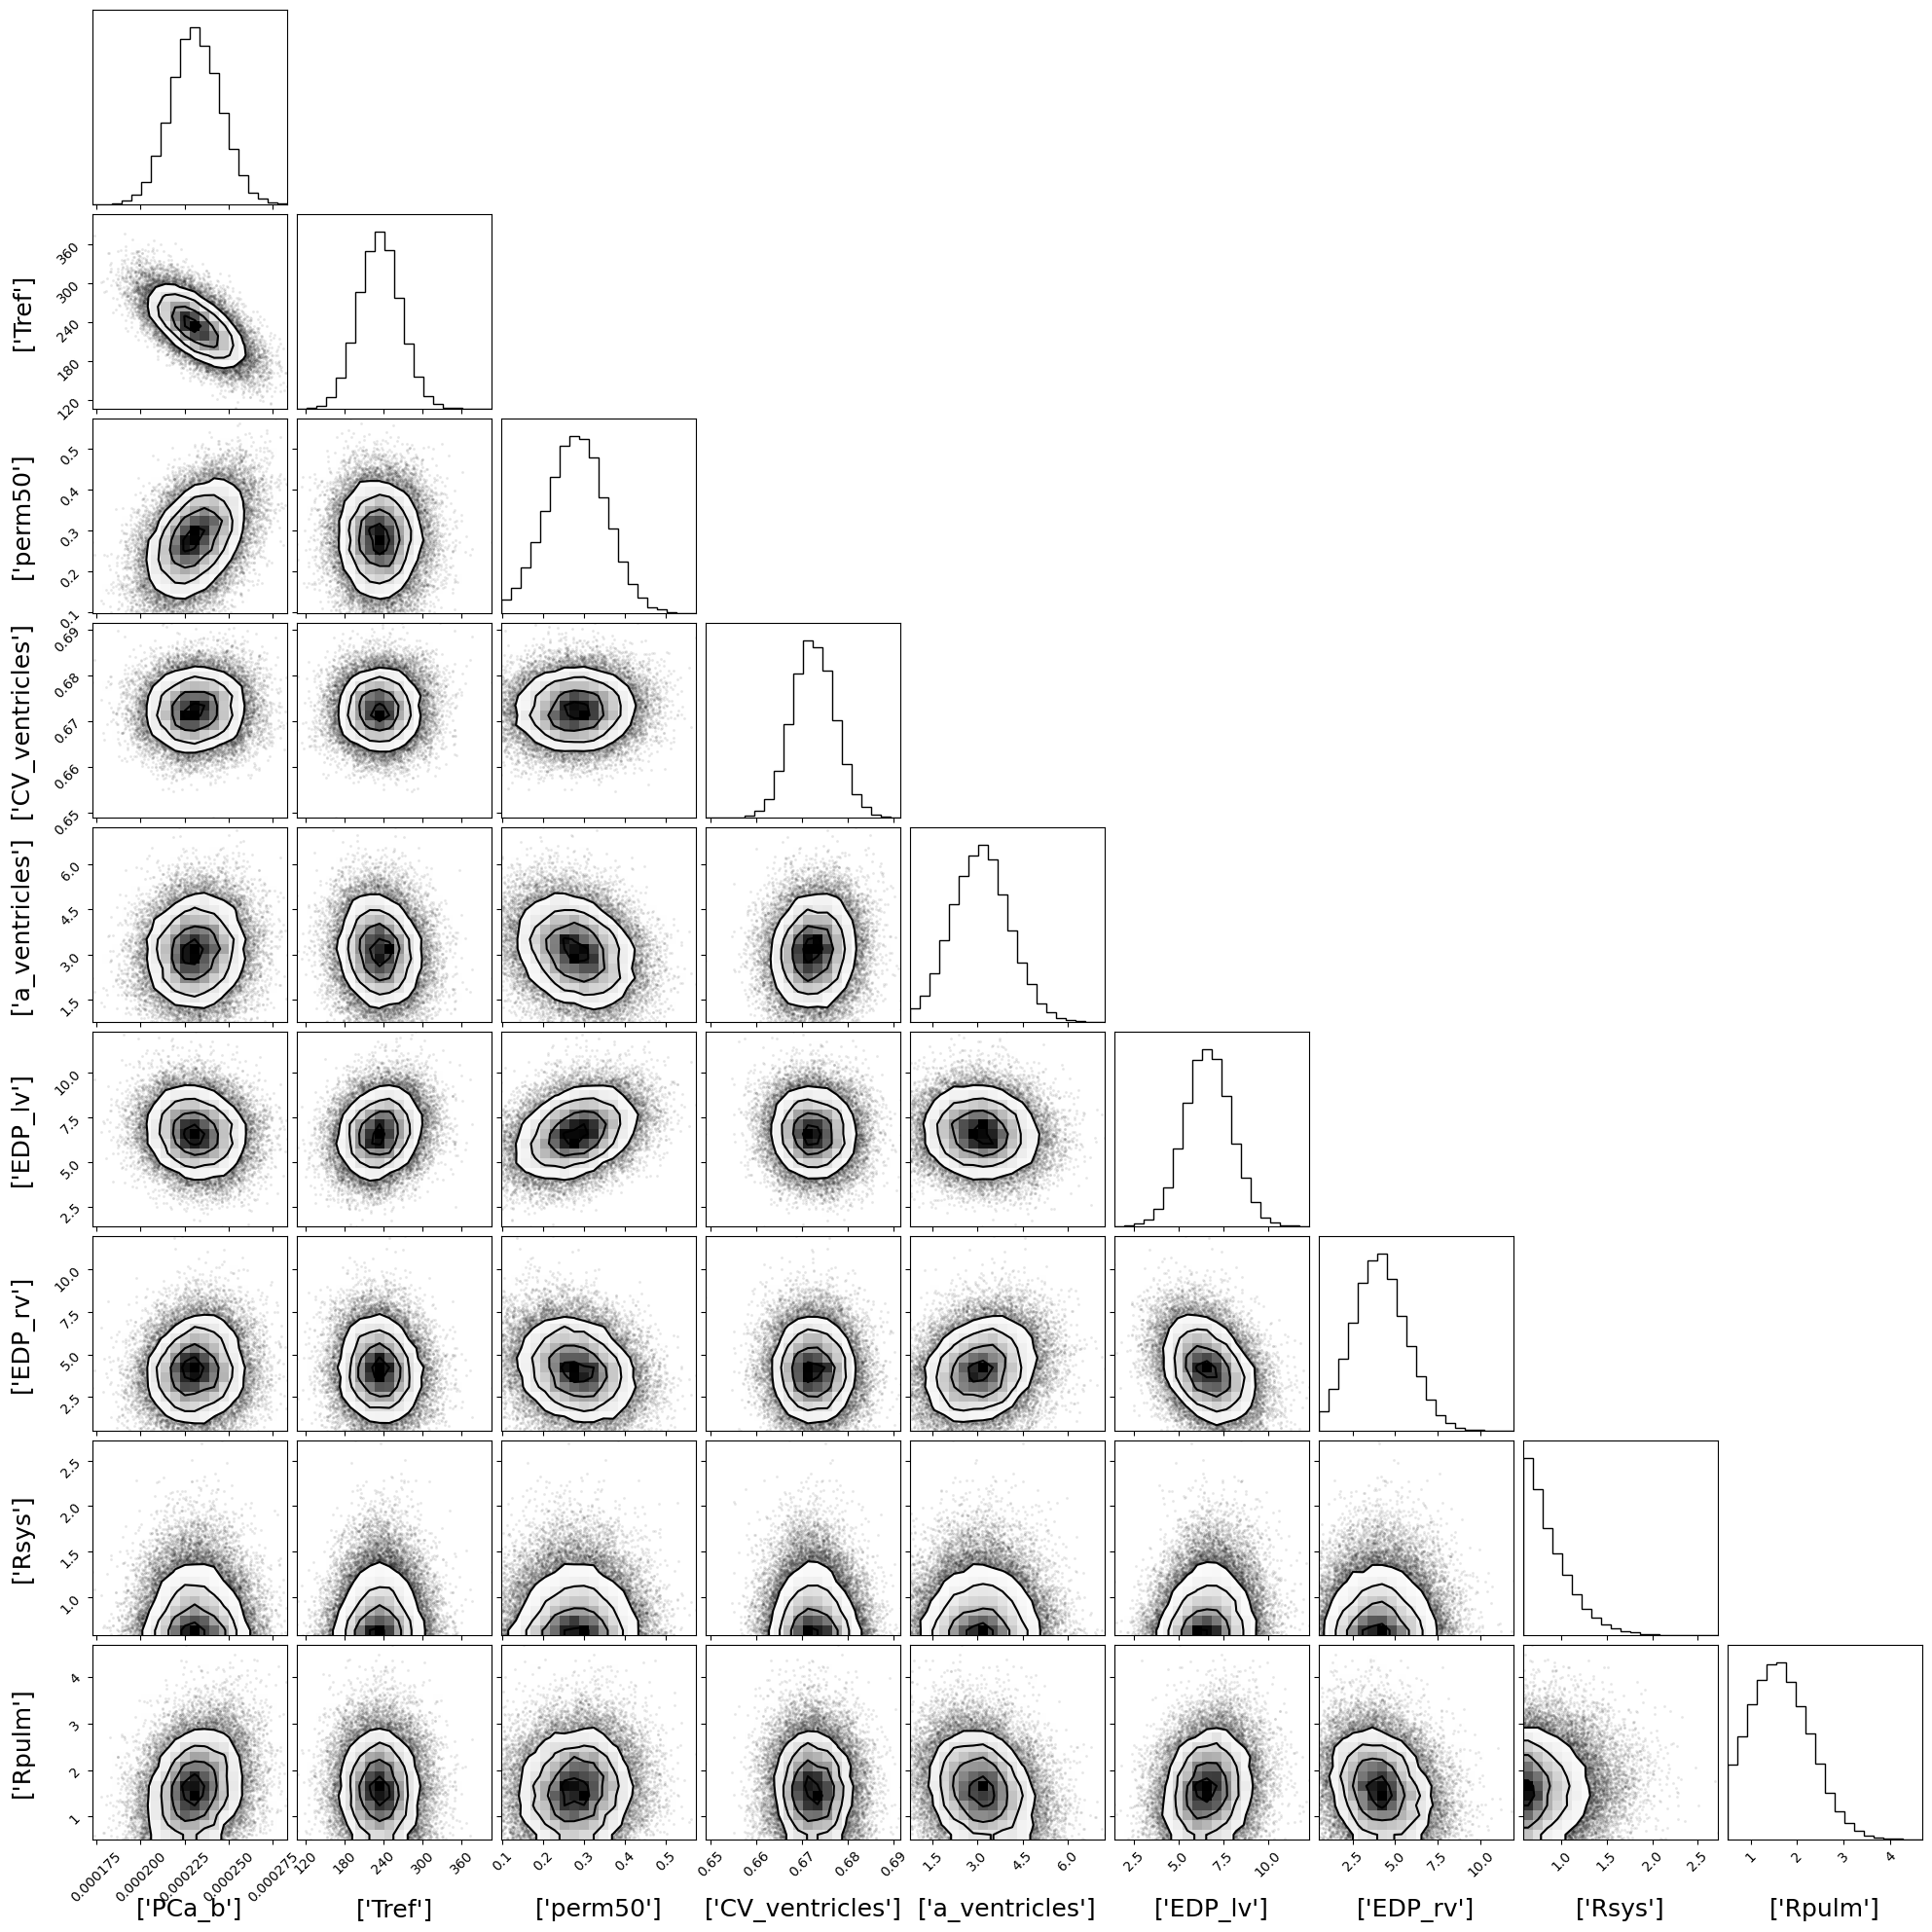

In [104]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [105]:
samp = pd.DataFrame(flat_samples).sample(50)

In [116]:
samp.to_csv("MCMC_samples_scenario_6_80_2timesUpper.dat", sep = " ",index=False,header=None)

In [107]:
flat_samples.mean(axis=0)

array([2.31250131e-04, 2.34284082e+02, 2.80831964e-01, 6.72526907e-01,
       3.11433334e+00, 6.63730599e+00, 4.13397412e+00, 8.80319624e-01,
       1.66034589e+00])

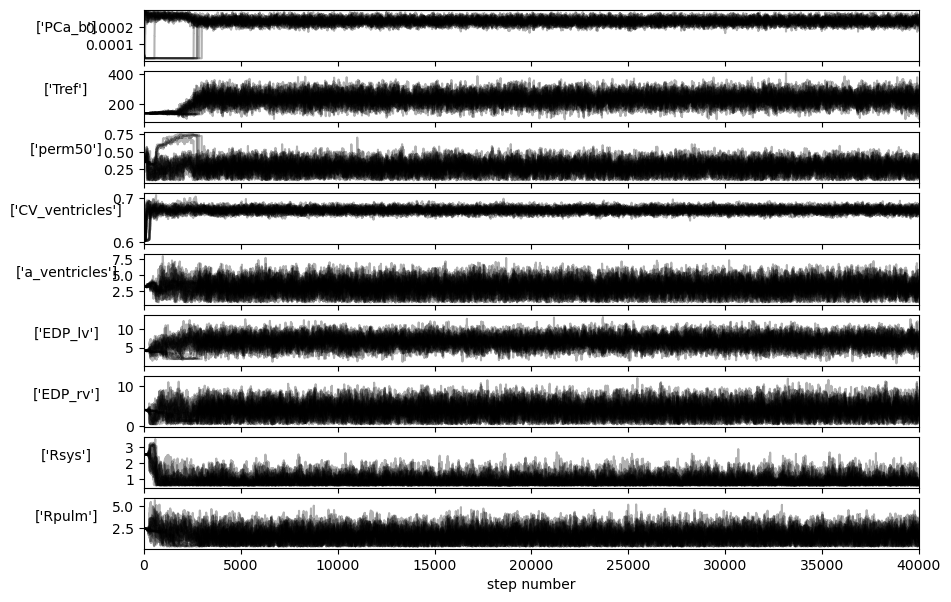

In [108]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [111]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [112]:
y_calibration

tensor([[1.5381e+02, 6.6530e+01, 1.8571e-01],
        [8.5098e+01, 4.7910e+01, 1.1001e-01],
        [1.1561e+02, 1.9400e+01, 3.9093e-02],
        [8.9510e+01, 6.7000e+01, 1.3606e-01],
        [9.1255e+01, 5.2720e+01, 8.2417e-02],
        [9.7075e+01, 6.9190e+01, 1.6742e-01],
        [1.6388e+02, 3.4620e+01, 3.3551e-02],
        [1.3055e+02, 6.1690e+01, 1.1383e-01],
        [9.4891e+01, 3.1880e+01, 9.8825e-02],
        [9.8627e+01, 6.9360e+01, 2.9462e-01],
        [1.3113e+02, 6.0730e+01, 1.2260e-01],
        [8.8125e+01, 2.9500e+01, 4.1594e-02],
        [1.3054e+02, 6.9350e+01, 1.8217e-01],
        [8.8239e+01, 7.4140e+01, 2.1337e-01],
        [1.3059e+02, 4.7210e+01, 9.8420e-02],
        [1.6401e+02, 4.1550e+01, 1.7519e-01],
        [1.5697e+02, 4.8750e+01, 9.0302e-02],
        [1.2477e+02, 6.0800e+01, 1.4216e-01],
        [9.9928e+01, 6.6170e+01, 2.3435e-01],
        [1.1112e+02, 7.7210e+01, 3.3089e-01],
        [1.1840e+02, 1.4640e+01, 3.7300e-02],
        [1.2397e+02, 6.0120e+01, 3

In [113]:
x_out.shape

torch.Size([9])

In [114]:
emulator.predict(x_out[None,:])

tensor([[100.0450, 156.6860,   0.7109]], grad_fn=<PermuteBackward0>)

In [ ]:
torch.tensor(flat_samples.T).shape

In [ ]:
plt.hist(emulator.predict(torch.tensor(flat_samples))[:,3].detach().numpy())

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
working = model.predict(flat_samples)

In [ ]:
plt.plot(working,'o')

# Calibration with fixed inputs

In [ ]:
new_input=input_masked.copy()
new_input=new_input.drop(['CV_atria','a_atria','a_ventricles'],axis=1)

In [ ]:
emulator = GPE.ensemble(new_input,y_calibration,mean_func="linear",training_iter=500)

In [ ]:
nDim = new_input.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(new_input.iloc[:,i]),np.max(new_input.iloc[:,i])])
    print(boundsMaxMin[i])

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
nDim

In [ ]:
import emcee
ndim = nDim
nwalkers = 16
p0 = np.random.multivariate_normal(centre, 0.001*np.identity(ndim), size=(nwalkers))
y_val = [100,157,111,0.5]

In [ ]:
x_labels.values.squeeze().tolist()

In [ ]:
new_input.columns

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=pd.DataFrame(x).T
    x.columns = new_input.columns.values.squeeze().tolist()
    y_val = pd.DataFrame(y_val).T
    y_val.columns = y_calibration.columns.values.squeeze().tolist()
    ll =np.sum(emulator.ensemble_log_likelihood(x,y_val))
    return ll

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
sampler.run_mcmc(p0, 30000)

In [ ]:
flat_samples = sampler.get_chain(discard=6000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_5_90.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = pd.DataFrame(flat_samples.mean(axis=0)).T
x_out.columns = new_input.columns.values.squeeze()

In [ ]:
y_calibration.columns

In [ ]:
emulator.predict(x_out)

In [ ]:
plt.hist(emulator.predict(pd.DataFrame(flat_samples,columns=input_masked.columns))[:,3].detach().numpy())

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

# Multi-Output GP

In [ ]:
import mogptk

In [ ]:
y_calibration

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_calibration
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration2.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_calibration2.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=4)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='Adam', lr=0.1, iters=7000, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

In [ ]:
emulator.MSE(X_test,y_test)

In [ ]:
model.plot_correlation()

In [ ]:
model.print_parameters()

In [ ]:
params?

In [ ]:
params = []

for p in model.parameters():
    params.append(p)

In [ ]:
params

In [ ]:
plt.imshow([[0.0009756545815890106, 0.0, 0.0, 0.0, 27819.543719613113, 0.0, 0.0, 0.0], [1.7460115277182566, 0.0, 0.0, 119410.25481699423, 0.0, 0.0, 0.0, 0.0], [11.369120898808664, 115237.02973475368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6990749064961943, 0.0, 0.0, 74757.56112865475, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
plt.imshow([[10.162908005474888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [37.97208882285453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [35.583222651507306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.01360765548753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_all
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_all.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='SGD', lr=0.01, iters=3500, plot=True, error='MSE', verbose=True);

In [ ]:
model.train(method='SGD', lr=0.01, iters=500, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
model.plot_correlation()

In [ ]:
fig, ax = model.plot_correlation(figsize=(25, 25))

In [ ]:
start=time.time()
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

end = time.time()
print(end - start)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
X_test

In [ ]:
import cigp_v10 as cig

In [ ]:
model = cig.cigp(torch.tensor(X_train.values),torch.tensor(y_train.values),normal_y_mode=1)

In [ ]:
import time
start = time.time()


model.train_adam(niteration=500)



In [ ]:
(torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]

In [ ]:
mogptMSE = np.array([9.10333333e-01, 1.33455636e-02, 8.78157403e-01, 6.69582124e-01,
       3.70024071e+02, 1.23460430e+02, 6.35753356e-01, 6.52791491e-04,
       3.76409392e-01, 5.31805275e-01, 1.71110574e+02, 5.49810697e+00,
       1.05649088e-01, 7.97417780e-02, 1.55348111e-01, 1.24083716e-02,
       5.45010526e-02, 5.65038223e-02, 1.02820944e-01, 1.11955787e-03,
       2.06413166e-02, 1.92173725e-02, 5.43121107e-02, 2.30204748e-02,
       1.96869906e-02, 1.69456459e-02, 1.63021757e+01, 1.57392304e+00])

In [ ]:
GPMSE = emulator.MSE(X_test,y_test).detach().numpy()
CIGMSE=((torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]).detach().numpy()

In [ ]:
fig, ax = plt.subplots()



im=plt.plot(1-GPMSE/np.var(y_test,axis=0),'o')
plt.plot(1-mogptMSE/np.var(y_test,axis=0),'o')
plt.plot(1-CIGMSE/np.var(y_test,axis=0),'o')
plt.legend(('GP','MOGPT','CIGP'))


plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
np.var(y_test,axis=0)

In [ ]:
y_all.iloc[:,[4]].max()

In [ ]:
y_all.iloc[:,[4]].min()

In [ ]:
y_all.iloc[:,[4]].std()